In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import seaborn as sns
import sklearn
from sklearn import linear_model
from sklearn import preprocessing
%matplotlib inline
sns.set_style('white')

In [2]:
df = pd.read_csv(
    'https://vincentarelbundock.github.io/Rdatasets/csv/ISLR/Default.csv'
).iloc[:, 1:].dropna()

df.head()

,default,student,balance,income
0,No,No,729.526495,44361.625074
1,No,Yes,817.180407,12106.134700
2,No,No,1073.549164,31767.138947
3,No,No,529.250605,35704.493935
4,No,No,785.655883,38463.495879


In [3]:
df.shape

(10000, 4)

In [4]:
# Recode strings to numeric.
df['default'] = np.where(df['default'] == 'Yes', 1, 0)
df['student'] = np.where(df['student'] == 'Yes', 1, 0)
names = df.columns
df = pd.DataFrame(preprocessing.scale(df), columns=names)

In [5]:
trainsize = int(len(df) / 2)
df_test = df.iloc[trainsize:, :].copy()
df_train = df.iloc[:trainsize, :].copy()

In [6]:
regr1 = linear_model.LinearRegression()
Y_train = df_train['income'].values.reshape(-1,1)
X_train = df_train.loc[:, ~(df_train.columns).isin(['income'])]

In [7]:
regr1.fit(X_train, Y_train)
print('R-squared simple model:')
print(regr1.score(X_train, Y_train))

R-squared simple model:
0.573878496272


In [8]:
origparams = np.append(regr1.coef_, regr1.intercept_)

In [9]:
regr1.coef_

array([[  1.36873063e-02,  -7.59472350e-01,   2.21504775e-05]])

In [10]:
regr1.intercept_

array([-0.00146122])

In [11]:
# Make new features to capture potential quadratic and cubic relationships
# between the features.
df_train['balance_student'] = df_train['balance'] * df_train['student']
df_train['balance_default'] = df_train['balance'] * df_train['default']
df_train['student_default'] = df_train['student'] * df_train['default']
df_train['balance_sqrt'] = (df_train['balance'] + 100) ** .5
df_train['balance2'] = (df_train['balance'] + 100) ** 2
df_train['balance3'] = (df_train['balance'] + 100) ** 3

In [12]:
# Re-run the model with the new features.
regrBig = linear_model.LinearRegression()
X_train2 = df_train.loc[:, ~(df_train.columns).isin(['income'])]
regrBig.fit(X_train2, Y_train)
print('\nR-squared complex model:')
print(regrBig.score(X_train2, Y_train))


R-squared complex model:
0.573973445208


In [13]:
# Store the new parameter estimates for the same features.
newparams = np.append(
    regrBig.coef_[0,0:(len(origparams)-1)],
    regrBig.intercept_)

In [14]:
# Note huge intercept
newparams

array([ -3.96993982e-03,  -7.58973694e-01,   4.15786644e+03,
         5.53434559e+05])

In [15]:
regrBig.coef_

array([[ -3.96993982e-03,  -7.58973694e-01,   4.15786644e+03,
         -1.68004292e-03,   1.16352676e-02,  -4.46055294e-03,
         -4.42024817e+04,  -1.39454982e+01,   2.80452411e-02]])

In [16]:
# Test the simpler model with smaller coefficients.
Y_test = df_test['income'].values.reshape(-1, 1)
X_test = df_test.loc[:, ~(df_test.columns).isin(['income'])]
print('\nR-squared simple model, test data:')
print(regr1.score(X_test, Y_test))


R-squared simple model, test data:
0.56306979225


In [17]:
df_test['balance_student'] = df_test['balance'] * df_test['student']
df_test['balance_default'] = df_test['balance'] * df_test['default']
df_test['student_default'] = df_test['student'] * df_test['default']
df_test['balance_sqrt'] = (df_test['balance'] + 100) ** .5
df_test['balance2'] = (df_test['balance'] + 100) ** 2
df_test['balance3'] = (df_test['balance'] + 100) ** 3

In [18]:
X_test2 = df_test.loc[:, ~(df_test.columns).isin(['income'])]
#regrBig.fit(X_test2, Y_test)
print('\nR-squared complex model, test data:')
print(regrBig.score(X_test2, Y_test))


R-squared complex model, test data:
0.563023952736


In [19]:
ridgeregr = linear_model.Ridge(alpha=10, fit_intercept=False) 
ridgeregr.fit(X_train, Y_train)
print(ridgeregr.score(X_train, Y_train))
origparams = ridgeregr.coef_[0]
print(origparams)

0.57387391644
[  1.36988466e-02  -7.57859433e-01  -3.25298557e-04]


In [20]:
ridgeregrBig = linear_model.Ridge(alpha=10, fit_intercept=False)
ridgeregrBig.fit(X_train2, Y_train)
print(ridgeregrBig.score(X_train2, Y_train))
newparams = ridgeregrBig.coef_[0, 0:len(origparams)]

print('\nParameter Estimates for the same predictors for the small model'
      'and large model:')
compare = np.column_stack((origparams, newparams))
prettycompare = np.array2string(
    compare,
    formatter={'float_kind':'{0:.3f}'.format})
print(prettycompare)

0.573946428961

Parameter Estimates for the same predictors for the small modeland large model:
[[0.014 -0.002]
 [-0.758 -0.757]
 [-0.000 0.048]]


### Compare the Ridge Regression and LASSO Models
Here we run both models with varying lambda (alpha) values, and see how the r-squared accuracy varies for each model. As we can see, the accuracy using the LASSO model takes a sharp drop-off almost from lambda=0, stabilizing at a lambda value of about 0.75 . From there the accuracy is constant at 2.68%. 

The Ridge Regression model experiences a steadier reduction, with a more or less linear (but extremely slight) decline after lambda = 200.

In [81]:
# Ridge Regression

#alphas = np.arange(0,2,0.05)
alphas = [0.01, 0.1, 0.5, 0.75, 1, 1.5, 2,5,10,20,50,75,100, 200, 500]  
rsquareds_ridge = []
for a in alphas:
    ridgeregrBig = linear_model.Ridge(alpha=a, fit_intercept=False)
    ridgeregrBig.fit(X_train2, Y_train)
    rsquareds_ridge.append(ridgeregrBig.score(X_train2, Y_train))
        
# LASSO Regression

rsquareds_LASSO = []

for a in alphas:
    lassBig = linear_model.Lasso(alpha=a)
    lassBig.fit(X_train2, Y_train)
    ridgeregrBig.fit(X_train2, Y_train)
    rsquareds_LASSO.append(lassBig.score(X_train2, Y_train))

results = pd.DataFrame({'alpha':alphas, 'r_sqr_ridge':rsquareds_ridge, 
                       'r_sqr_lass':rsquareds_LASSO})  
results.head()

,alpha,r_sqr_lass,r_sqr_ridge
0,0.01,0.573768,0.573972
1,0.10,0.563089,0.573972
2,0.50,0.308250,0.573971
3,0.75,0.026834,0.573970
4,1.00,0.026834,0.573969


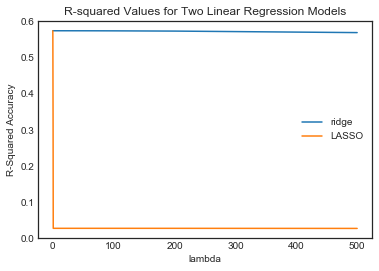

In [82]:
labels = ['ridge', 'LASSO']
plt.plot(results['alpha'], results['r_sqr_ridge'])
plt.plot(results['alpha'], results['r_sqr_lass'])
plt.title('R-squared Values for Two Linear Regression Models')
plt.xlabel('lambda')
plt.ylabel('R-Squared Accuracy')
plt.legend(labels)
plt.show()

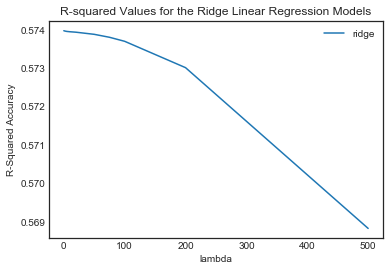

In [83]:
plt.plot(results['alpha'], results['r_sqr_ridge'])
plt.title('R-squared Values for the Ridge Linear Regression Models')
plt.xlabel('lambda')
plt.ylabel('R-Squared Accuracy')
plt.legend(['ridge'])
plt.show()

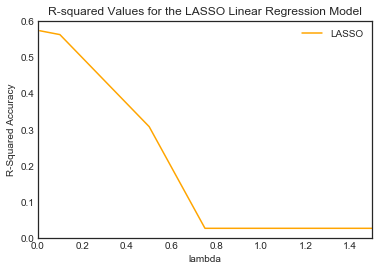

In [84]:
plt.plot(results['alpha'], results['r_sqr_lass'], color='orange')
plt.title('R-squared Values for the LASSO Linear Regression Model')
plt.xlabel('lambda')
plt.xlim(0, 1.5)
plt.ylabel('R-Squared Accuracy')
plt.legend(['LASSO'])
plt.show()